# Handwritten Text Recognition and Conversion Using Convolutional Neural Network (CNN) Based Deep Learning Model

#### Description
This research paper aims to implement an efficient algorithm for converting handwritten text into digital format using convolutional neural networks (CNNs), recurrent neural networks (RNNs), and Connectionist Temporal Classification Loss (CTC). In order to achieve this, the following steps will be followed:

##### Preprocessing the dataset:
- Resizing the image while maintaining its aspect ratio 
- Vectorizing the labels
##### Building the model
##### Training the model
##### Predicting the output  
Link to <a link='https://ieeexplore.ieee.org/document/9544513'>IEEE Paper</a> and <a link='https://fki.tic.heia-fr.ch/databases/iam-handwriting-database'>IAM Data Set</a>

In [1]:
# importing the library
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

## Data Processing

In [2]:
# Base path for the dataset
base_path = 'dataSet'

In [3]:
# Extracting lines form the words_new.txt in order to get the label and file name for the input data
words_new = open(f'{base_path}/words_new.txt', 'r')
lines = words_new.readlines() # contains all the lines from the file(words_new.txt) 
words_new.close()

correct_samples = [] # Array contaning correctly classified labels
for line in lines:
    if line[0] == '#':# We need to drop the initial few lines of the .txt file because the explain how the data is represented in the .txt file
        continue
    else:
        line_array = line.split(" ")
        if line_array[1] == 'err': # there are some misclassifired samples we need to collect only correct smples
            continue
        else:
            correct_samples.append(line)

print("Total number of correct sampels:",len(correct_samples))

FileNotFoundError: [Errno 2] No such file or directory: 'dataSet/words_new.txt'

In [4]:
# Base path for the images
img_base_path = f"{base_path}/iam_words/words/"

max_length      = 0     # maximum length of the label
image_path      = []    # array containing path for images
image_label     = []    # array containing label for i'th image(image_path[i])
characters      = set() # set of all the characters in the label
for line in correct_samples:
    file_name = line.split(" ")[0]
    folder_1  = file_name.split("-")[0]
    folder_2  = file_name.split("-")[1]

    temp_label = line.split(" ")[-1].strip() # label(last element of my line is the label)
    temp_path  = f"{base_path}/iam_words/words/{folder_1}/{folder_1}-{folder_2}/{file_name}.png" # path of the image for that corresponding label.
    if os.path.exists(temp_path): # if the image exists then we can add it to the dataset 
        image_label.append(temp_label)
        image_path.append(temp_path)
        max_length = max(max_length,len(temp_label))
        for char in temp_label:
            characters.add(char)

data_length = len(image_path)
char_length = len(characters)
characters = sorted(list(characters))
print(f"len(image_path):",len(image_path))
print(f"len(image_label):",len(image_label))

len(image_path): 38304
len(image_label): 38304


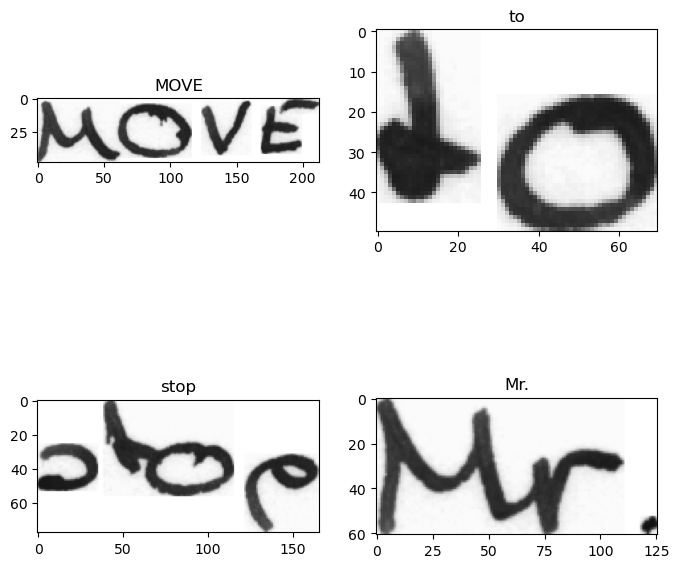

In [5]:
# lets see some sample images and their corresponding image_lanbel
fig = plt.figure(figsize=(8,8))
for i in range(1, 5):
    temp_img = cv.imread(image_path[i])
    plt.subplot(2, 2, i)
    plt.imshow(temp_img)
    plt.title(image_label[i])

plt.show()

As we can see the size of the image is not uniform so we need to resize the image without affecting the aspect ratio.

### Spliting the Correct samples in the 90:5:5 ratio Training: Testing: Validation

In [6]:
train_length        = int(0.90*data_length)
test_length         = int(0.05*data_length)
validation_length   = int(0.05*data_length)

train_path, train_label             = image_path[:train_length], image_label[:train_length]
test_path, test_label               = image_path[train_length:test_length+train_length], image_label[train_length:test_length+train_length]
validation_path, validation_label = image_path[test_length+train_length:], image_label[test_length+train_length:]

print(f"len(train_path)     :",len(train_path))
print(f"len(test_path)      :",len(test_path))
print(f"len(validation_path):",len(validation_path))

print(f"Total:",len(train_path)+len(test_path)+len(validation_path))

len(train_path)     : 34473
len(test_path)      : 1915
len(validation_path): 1916
Total: 38304


##### As the images are not of uniform size we need the make them uniform

In [7]:
# function to resize the image with padding
def image_resize(image):
    image = tf.image.resize_with_pad(image, target_height = 32, target_width=128)
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [8]:
# function to resize the image and scale down the parameters from [0-255] to [0-1]
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = image_resize(image)
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
# Mapping each character a number 
char_num = tf.keras.layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_char = tf.keras.layers.StringLookup(vocabulary=char_num.get_vocabulary(), mask_token=None, invert=True)

In [10]:
# function to vectorize the labels i.e. convert 'car' -> {'c','a','r'}
def vectorize(label):
    label = char_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    temp_length = tf.shape(label)[0]
    padding_amount = max_length - temp_length
    label = tf.pad(label, paddings=[[0, padding_amount]], constant_values=100)
    return label

In [11]:
# function to design a dictonary of images and their corresponding labels
def dataset_generator(image_path, image_label):
    temp_img = preprocess_image(image_path)
    temp_label = vectorize(image_label)
    return {"image":temp_img, "label":temp_label}

In [12]:
# Function to generate the dataset
def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        dataset_generator, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(64).cache().prefetch(AUTOTUNE)

In [13]:
training_dataset = prepare_dataset(train_path, train_label)

In [14]:
test_dataset = prepare_dataset(test_path, test_label)

In [15]:
valid_dataset = prepare_dataset(validation_path, validation_label)

In [16]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = tf.keras.Input(shape=(128, 32, 1), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="CNN-1",
    )(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="POOL-1")(x)

    # Second conv block.
    x = tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="CNN-2",
    )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="POOL-2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((128 // 4), (32 // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    x = tf.keras.layers.Dense(
        len(char_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = tf.keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 CNN-1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 POOL-1 (MaxPooling2D)          (None, 64, 16, 32)   0           ['CNN-1[0][0]']                  
                                                                                                  
 CNN-2 (Conv2D)                 (None, 64, 16, 64)   18496       ['POOL-1[0][

In [17]:
epochs = 50  # To get good results this should be at least 50.

# Train the model.
history = model.fit(
    training_dataset,
    validation_data=valid_dataset,
    epochs=epochs
)

Epoch 1/50
539/539 [==============================] - 155s 254ms/step - loss: 15.9101 - val_loss: 13.4180
Epoch 2/50
539/539 [==============================] - 34s 63ms/step - loss: 13.8189 - val_loss: 12.5580
Epoch 3/50
539/539 [==============================] - 75s 139ms/step - loss: 13.0932 - val_loss: 11.7483
Epoch 4/50
539/539 [==============================] - 38s 70ms/step - loss: 12.5403 - val_loss: 11.1554
Epoch 5/50
539/539 [==============================] - 30s 56ms/step - loss: 11.9549 - val_loss: 10.5508
Epoch 6/50
539/539 [==============================] - 30s 56ms/step - loss: 11.3425 - val_loss: 9.9979
Epoch 7/50
539/539 [==============================] - 30s 56ms/step - loss: 10.8223 - val_loss: 9.5089
Epoch 8/50
539/539 [==============================] - 96s 179ms/step - loss: 10.2937 - val_loss: 9.1119
Epoch 9/50
539/539 [==============================] - 67s 124ms/step - loss: 9.7632 - val_loss: 8.6094
Epoch 10/50
539/539 [==============================] - 36s 67ms/

In [22]:

prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

In [23]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

2/2 [==============================] - 0s 54ms/step


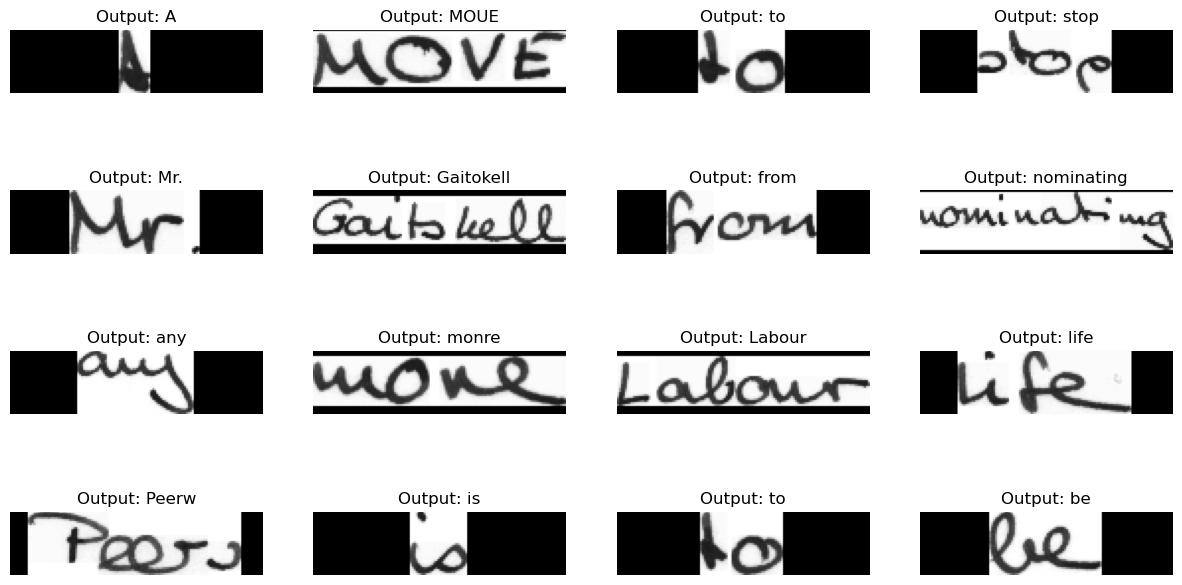

In [49]:
for batch in training_dataset.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # print(pred_texts[i])
        title = f"Output: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [25]:
model.save('ds303_project_model')

INFO:tensorflow:Assets written to: ds303_project_model\assets


INFO:tensorflow:Assets written to: ds303_project_model\assets


In [27]:
my_model = model = tf.keras.models.load_model('ds303_project_model')